# Favorita Stores Sales
---

## Step 1: Business Understanding 
You are a data scientist in Corporation Favorita, a large Ecuadorian-based grocery retailer. Corporation Favorita wants to ensure that they always have the right quantity of products in stock. To do this you have decided to build a series of machine learning models to forecast the demand of products in various locations. The marketing and sales team have provided you with some data to aid this endeavor. Your team uses CRISP-DM Framework for Data Science projects

This is a time series regression analysis problem. In this project, you'll predict store sales on data from Corporation Favorita, a large Ecuadorian-based grocery retailer.

#### Objective
In this analysis we will: 
- Answer analytical questions.
- Build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.

#### Analytical Questions
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

 
 


- Null Hypothesis (H0): There are no significant differences in 
Churn amongst the columns.
- Alternate Hypothesis (H1): There are significant differences in 
Churn amongst the columns.

## Step 2: Data Understanding
The data for this projects has been divided into 2. The one for training and evaluation and the other for testing.

#### Data Dictionary
The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

##### File Descriptions and Data Field Information

##### train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- __store_nbr__ identifies the store at which the products are sold.
- __family__ identifies the type of product sold.
- __sales__ gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- __onpromotion__ gives the total number of items in a product family that were being promoted at a store at a given date.

##### test.csv
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

##### transaction.csv
- Contains date, store_nbr and transaction made on that specific date.

##### sample_submission.csv
- A sample submission file in the correct format.

##### stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

##### oil.csv
- __Daily oil price (dcoilwtico)__ which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

##### holidays_events.csv
- Holidays and Events, with metadata

_NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer._

_For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge._

- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

##### Additional Notes
- Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.


### Step 1: Load Data

#### Import the necessary packages 

In [84]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings("ignore")  # Hiding the warnings

# environment variables
from dotenv import dotenv_values

# Database Connection
import pyodbc

# Statistical models
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Imputers
from sklearn.impute import SimpleImputer

#### Load The Oil, Holidays and Stores Data


Establishing a connection to the SQL database

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the .env file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("UID")
password = environment_variables.get("PWD")

# Create the connection string using the retrieved credentials
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

print(connection_string)

DRIVER={SQL Server};SERVER=dap-projects-database.database.windows.net;DATABASE=dapDB;UID=learning_project_3;PWD=A$uB1Lp3$2@24;MARS_Connection=yes;MinProtocolVersion=TLSv1.2;


Oil Data

In [3]:
            #----------Load & export oil data----------
# Establish a connection to the database using the connection string
connection = pyodbc.connect(connection_string) 

# Define the SQL query to select all columns from the specified table
query = "Select * from dbo.oil"

# Execute the SQL query and fetch the result into a pandas DataFrame using the established database connection
oil_df = pd.read_sql(query, connection)

# Print out document shape
print("Oil data:",oil_df.shape)

# View the result
oil_df.head()

Oil data: (1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


Holidays Data

In [4]:
             #----------Load & export holiday data----------
# Define the SQL query to select all columns from the specified table
query = "Select * from dbo.holidays_events"

# Execute the SQL query and fetch the result into a pandas DataFrame using the established database connection
holidays_df = pd.read_sql(query, connection)

# Print out document shape
print("Holidays data:",holidays_df.shape)

# View the result
holidays_df.head()


Holidays data: (350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Stores Data

In [5]:
             #----------Load & export stores data----------
# Define the SQL query to select all columns from the specified table
query = "Select * from dbo.stores"

# Execute the SQL query and fetch the result into a pandas DataFrame using the established database connection
stores_df = pd.read_sql(query, connection)

# Print out document shape
print("Stores data:",stores_df.shape)

# View the result
stores_df.head()


Stores data: (54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


 #### Load train and transactions csv Data

In [6]:
# Read train.csv document
train_df = pd.read_csv(r"C:\Users\Pc\Desktop\Data analysis\Azubi Africa\Career Accelerator\LP3\Time-Series-Regression-Analysis-Corporation-Favorita-\Data\Training & Eval\train.csv")

# Print out document shape
print("Train data:",train_df.shape)

# View the result
train_df.head()

Train data: (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [7]:
# Read train.csc document
transactions_df = pd.read_csv(r"C:\Users\Pc\Desktop\Data analysis\Azubi Africa\Career Accelerator\LP3\Time-Series-Regression-Analysis-Corporation-Favorita-\Data\Training & Eval\transactions.csv")

# Print out document shape
print("Transactions data:",transactions_df.shape)

# View the result
transactions_df.head()

Transactions data: (83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


#### Load Data for Testing

In [8]:
# Read train.csv document
test_df = pd.read_csv(r"C:\Users\Pc\Desktop\Data analysis\Azubi Africa\Career Accelerator\LP3\Time-Series-Regression-Analysis-Corporation-Favorita-\Data\Testing\test.csv")

# Print out document shape
print("Test data:",test_df.shape)

# View the result
test_df.head()

Test data: (28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Step 2: Analyze dataset

##### View data

Train data

In [9]:
# Display the first few rows of the train data
print("Train data:")
train_df.head()

Train data:


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Oil data


In [10]:
# Print out data shape
print("Oil data:")
oil_df.head()

Oil data:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


Holidays data

In [11]:
# Print out data shape
print("Holidays data:")
holidays_df.head()

Holidays data:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Stores data

In [12]:
# Print out data shape
print("Stores data:")
stores_df.head()

Stores data:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Transactions data

In [13]:
# Print out data shape
print("Transactions data:")
transactions_df.head()

Transactions data:


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


##### Analysis

In [14]:
dataframes = {
    "Train": train_df,
    "Transactions": transactions_df,
    "Test": test_df,
    "Oil": oil_df,
    "Stores": stores_df,
    "Holidays": holidays_df,
}

# View data shape and columns
for name in dataframes:
    print(f"{name} data shape: {dataframes[name].shape}")
    print(f"Columns: {dataframes[name].columns.tolist()}")
    print("="*50)

Train data shape: (3000888, 6)
Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']
Transactions data shape: (83488, 3)
Columns: ['date', 'store_nbr', 'transactions']
Test data shape: (28512, 5)
Columns: ['id', 'date', 'store_nbr', 'family', 'onpromotion']
Oil data shape: (1218, 2)
Columns: ['date', 'dcoilwtico']
Stores data shape: (54, 5)
Columns: ['store_nbr', 'city', 'state', 'type', 'cluster']
Holidays data shape: (350, 6)
Columns: ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']


__Key Insights__
- The train data (train_df) has the largest number of data followed by "transactions_df"

In [15]:
# Check the info of dataframes
for name, df in dataframes.items():
    print(f"{name} DataFrame info:")
    print(df.info())
    print("="*100)
    print(f"\n")

Train DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


Transactions DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None


Test DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------  

We need to convert the dtypes of the "data" columns in the all the datasets 

In [16]:
# Convert dtype of "date" column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# View Convertion
print("Train:", train_df['date'].dtype)
print("Transactions:", transactions_df['date'].dtype)
print("Test:", test_df['date'].dtype)
print("Oil:", oil_df['date'].dtype)
print("Holidays:", holidays_df['date'].dtype)


Train: datetime64[ns]
Transactions: datetime64[ns]
Test: datetime64[ns]
Oil: datetime64[ns]
Holidays: datetime64[ns]


__Key Insights__
- The dtype of the "date" columns has been successfully converted to datetime

In [17]:
# Check for duplicates
for name in dataframes:
    print(name)
    print(f"No of duplicates: {dataframes[name].duplicated().sum()}")
    print("="*50)

Train
No of duplicates: 0
Transactions
No of duplicates: 0
Test
No of duplicates: 0
Oil
No of duplicates: 0
Stores
No of duplicates: 0
Holidays
No of duplicates: 0


__Key Insight__
- There are  no duplicates in the datasets


In [18]:
# Check for null values
for name in dataframes:
    print(name)
    print(f"No of duplicates: {dataframes[name].isna().sum()}")
    print("="*50)
    print(f"\n")

Train
No of duplicates: id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


Transactions
No of duplicates: date            0
store_nbr       0
transactions    0
dtype: int64


Test
No of duplicates: id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


Oil
No of duplicates: date           0
dcoilwtico    43
dtype: int64


Stores
No of duplicates: store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


Holidays
No of duplicates: date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64




__Key Insight__
- The nulls values are only present at the "dcoilwtico" column in the oil_df dataframe. This must be investigated


##### Merging Data

In [85]:
# Merge all holidays, transaction and oil datasets on "date"
hot_df = oil_df.merge(holidays_df, on="date") \
             .merge(transactions_df, on="date")

# Merging hot_df and train_df on "date" and "store_nbr"
all_df= hot_df.merge(train_df, on=["date",'store_nbr'], how='inner')

print("Merged data shape:", all_df.shape)
all_df.head()

Merged data shape: (322047, 13)


,date,dcoilwtico,type,locale,locale_name,description,transferred,store_nbr,transactions,id,family,sales,onpromotion
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,25,770,561,AUTOMOTIVE,0.0,0
1,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,25,770,562,BABY CARE,0.0,0
2,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,25,770,563,BEAUTY,2.0,0
3,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,25,770,564,BEVERAGES,810.0,0
4,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,25,770,565,BOOKS,0.0,0


We can further investigate the null values of "dcoilwtico" column using the "df" DataFrame

In [75]:
dcoil_nulls= all_df[all_df['dcoilwtico'].isna()]

print("Data shape:",dcoil_nulls.shape)

# View data shape and columns
for column in dcoil_nulls.columns:
    print(f"{column}")
    print(f"Unique values: {dcoil_nulls[column].unique().tolist()}")
    print("="*50)

Data shape: (22044, 13)
date
Unique values: [Timestamp('2013-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-18 00:00:00'), Timestamp('2014-07-04 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2015-02-16 00:00:00'), Timestamp('2015-04-03 00:00:00'), Timestamp('2015-07-03 00:00:00'), Timestamp('2016-03-25 00:00:00'), Timestamp('2016-12-26 00:00:00'), Timestamp('2017-01-02 00:00:00'), Timestamp('2017-04-14 00:00:00'), Timestamp('2017-07-03 00:00:00')]
dcoilwtico
Unique values: [nan]
type
Unique values: ['Holiday', 'Event', 'Additional', 'Transfer']
locale
Unique values: ['National', 'Local']
locale_name
Unique values: ['Ecuador', 'El Carmen', 'Santo Domingo', 'Libertad']
description
Unique values: ['Primer dia del ano', 'Viernes Santo', 'Mundial de futbol Brasil: Cuartos de Final', 'Carnaval', 'Cantonizacion de El Carmen', 'Fundacion de Santo Domingo', 'Navidad+1', 'Traslado Primer dia del ano', 'Cantonizacion de Libertad']
transferred
Unique values: [Fal

In [115]:
# Calculate the total number of rows for the null and the whole data
num_nulls= all_nulls.shape[0]
num_data= all_df.shape[0]

# Calculate the percentage of null values

null_percentage= (num_nulls/num_data) * 100
null_percentage

print(f"Percentage of null values: {null_percentage:,.2f}%")

Percentage of null values: 6.84%


__Key Insights__
- The percentage of null values in the 'dcoilwtico' column is 6.84%, which is not a significant number. We can safely fill these nulls with the next available value using backfill.
- All null values in the "dcoilwtico" column have "False" value in the transferred column indicating that all their event types were not transferred.

In [95]:
# Fill the null values with the next available value using bfill
all_df['dcoilwtico'] = all_df['dcoilwtico'].fillna(method='bfill')

# view data
all_df.head()

,date,dcoilwtico,type,locale,locale_name,description,transferred,store_nbr,transactions,id,family,sales,onpromotion
0,2013-01-01,97.010002,Holiday,National,Ecuador,Primer dia del ano,False,25,770,561,AUTOMOTIVE,0.0,0
1,2013-01-01,97.010002,Holiday,National,Ecuador,Primer dia del ano,False,25,770,562,BABY CARE,0.0,0
2,2013-01-01,97.010002,Holiday,National,Ecuador,Primer dia del ano,False,25,770,563,BEAUTY,2.0,0
3,2013-01-01,97.010002,Holiday,National,Ecuador,Primer dia del ano,False,25,770,564,BEVERAGES,810.0,0
4,2013-01-01,97.010002,Holiday,National,Ecuador,Primer dia del ano,False,25,770,565,BOOKS,0.0,0


Null values filled successfully

##### __Summary__
- We used backfill to fill the null values in the 'dcoilwtico' column since the difference in oil price for each day are rarely signigicantly big and they represent only 6.8% of the data.
- The dtype of 'date' columns in each dataset was changed to 'datetime'.


### Step 3: Exploratory Data Analysis

#### Univariant Analysis

In [61]:
# View the train data
all_df.head()

,date,dcoilwtico,type,locale,locale_name,description,transferred,store_nbr,transactions,id,family,sales,onpromotion
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,25,770,561,AUTOMOTIVE,0.0,0
1,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,25,770,562,BABY CARE,0.0,0
2,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,25,770,563,BEAUTY,2.0,0
3,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,25,770,564,BEVERAGES,810.0,0
4,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,25,770,565,BOOKS,0.0,0


In [62]:
# Check the statistical describtion of the Train dataset
all_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,322047,2015-08-04 23:49:57.971104,2013-01-01 00:00:00,2014-07-23 00:00:00,2015-11-02 00:00:00,2016-05-27 00:00:00,2017-08-15 00:00:00,NaN
dcoilwtico,300003.0,64.077912,27.959999,44.66,51.439999,94.739998,107.949997,25.147682
store_nbr,322047.0,26.994672,1.0,13.0,27.0,40.0,54.0,15.595174
transactions,322047.0,1734.11784,54.0,1030.0,1409.0,2148.0,8359.0,1050.335018
id,322047.0,1682979.459576,561.0,1010616.5,1842406.0,2209555.5,3000887.0,786249.257767
sales,322047.0,406.383452,0.0,1.0,19.0,241.260505,124717.0,1246.88124
onpromotion,322047.0,3.727136,0.0,0.0,0.0,1.0,716.0,15.512095


__Key Insights__
- There are 54 stores in total
- The data collected ranges from early 2013 to late 2017
- The average sales amount is $406.38, with a wide range from $0 (for days that stores were closed) to $124,717.  to a maximum of $124,717.This shows a possiblity of outliers
- There were days that a max of 716 items were on promotion sales and days where nothing was on promotion.
- The average crude oil price is approximately $64.08, with a wide range from $27.96 to $107.95.

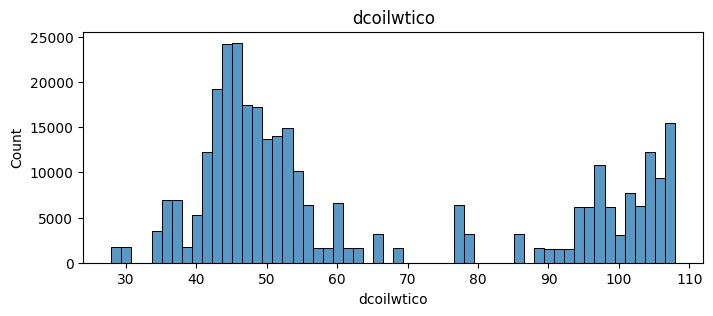

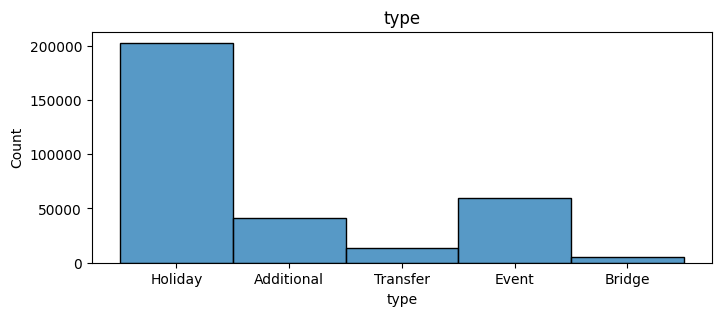

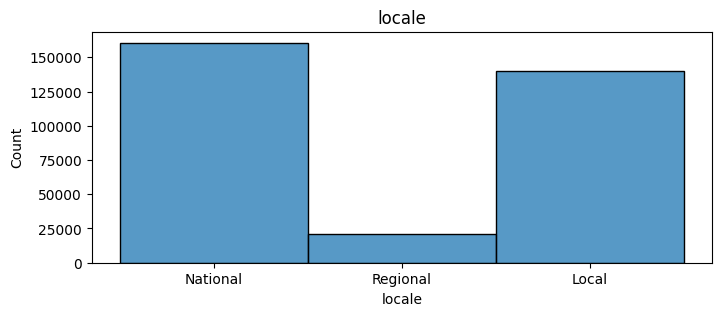

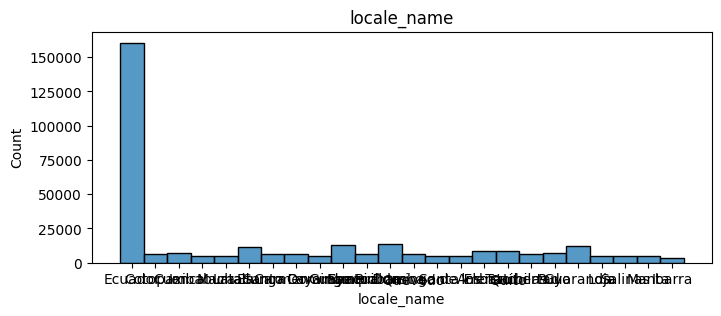

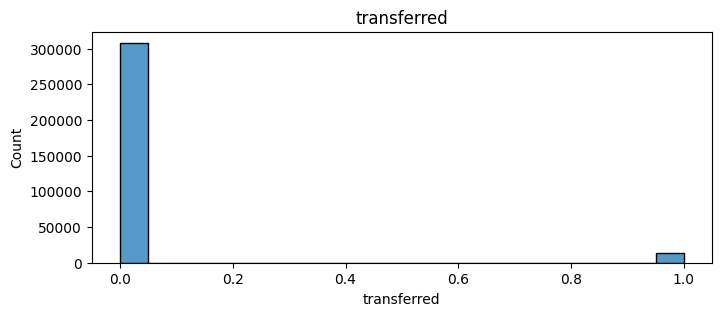

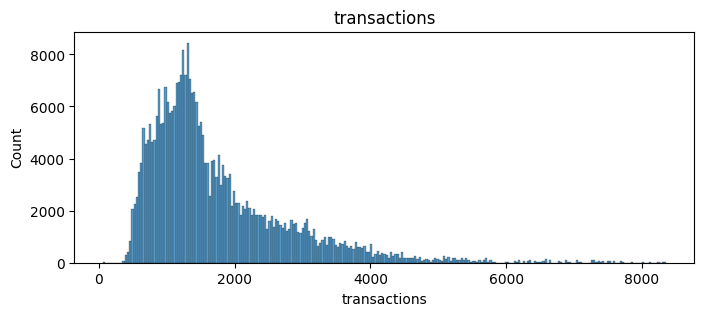

In [121]:
# Draw a boxplot for Sales and onpromotion
for column in all_df.drop(columns=['date','id','description','store_nbr','sales','onpromotion','family'], axis=1).columns:
    plt.figure(figsize=(8,3))
    sns.histplot(x=column, data=all_df)
    plt.title(f'{column}')
    plt.show()

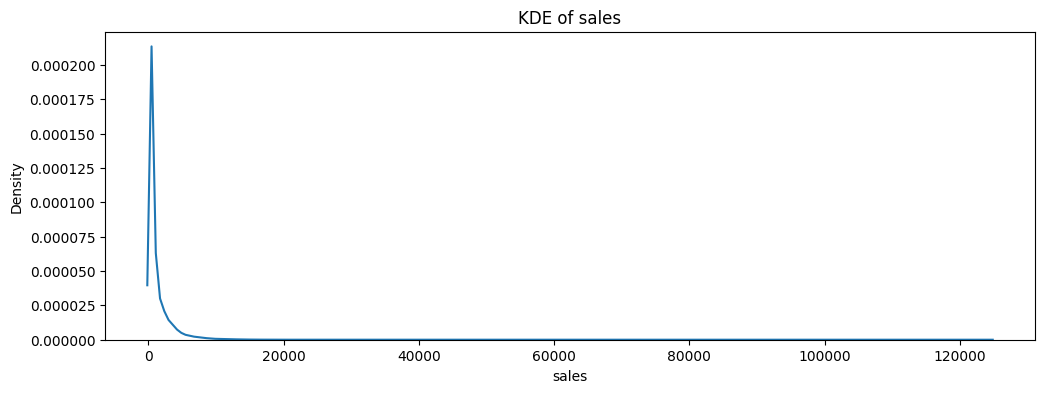

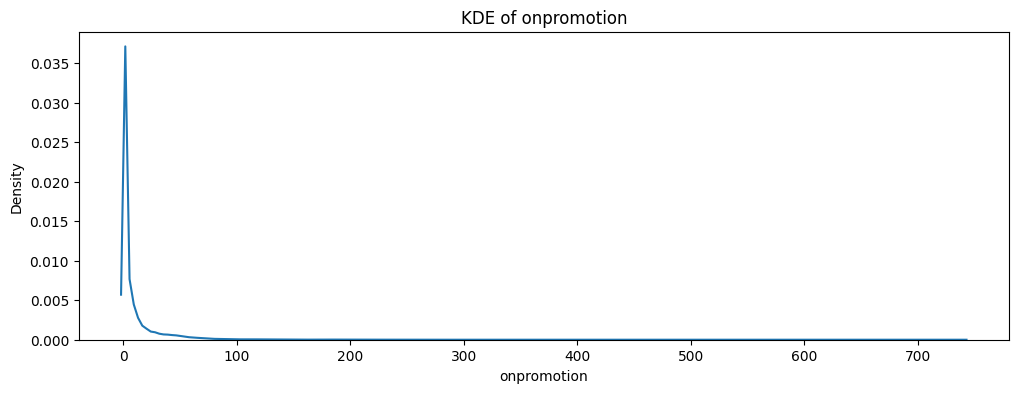

In [117]:
# Draw a kdeplot for Sales and onpromotion
for column in train_df[['sales','onpromotion']].columns:
    plt.figure(figsize=(12,4))
    sns.kdeplot(x=column, data=train_df)
    plt.title(f'KDE of {column}')
    plt.show()

__Key Insights__
- For most days oil price ranged between 40 to 50.
-  Most of the data came from the stores in Equador, This could indicate that most of the stores are located in Equador
- On most days the total count of transactions ranges from 1000 t0 2000 transactions
- The distribution of "sales" and "onpromotion" are highly skewed to the right.
- We can also see that majority of the sales are concentrated at the lower end of the scale with few very high sales values.
    - This suggests that while high sales can occur, they are rare events compared to the more low sales.
- There wasn't a lot of promotions throughout the years, only a small number of items are on promotion at any given time, and it is rare to have a very high number of items on promotion.

#### 1. Is the train dataset complete (has all the required dates)? 

In [188]:
train_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [196]:
train_df['date'].value_counts(ascending= False)

date
2017-08-15    1782
2013-01-01    1782
2013-01-02    1782
2013-01-03    1782
2017-07-30    1782
              ... 
2013-01-09    1782
2013-01-08    1782
2013-01-07    1782
2013-01-06    1782
2013-01-05    1782
Name: count, Length: 1684, dtype: int64

#### 2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)? 

In [198]:
# Extract year, months, month name and days from the data
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['month_name'] = train_df['date'].dt.month_name()
train_df['day'] = train_df['date'].dt.day

# Filter out dates that the store has not been closed


# View data
train_df

,id,date,store_nbr,family,sales,onpromotion,year,month,day,month_name
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,1,1,January
1,1,2013-01-01,1,BABY CARE,0.000,0,2013,1,1,January
2,2,2013-01-01,1,BEAUTY,0.000,0,2013,1,1,January
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013,1,1,January
4,4,2013-01-01,1,BOOKS,0.000,0,2013,1,1,January
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,15,August
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,August
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,August
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,August


In [200]:
# Merge train_df and oil_df on "date"
train_df.merge(oil_df, on="date")
train_df


,id,date,store_nbr,family,sales,onpromotion,year,month,day,month_name
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,1,1,January
1,1,2013-01-01,1,BABY CARE,0.000,0,2013,1,1,January
2,2,2013-01-01,1,BEAUTY,0.000,0,2013,1,1,January
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013,1,1,January
4,4,2013-01-01,1,BOOKS,0.000,0,2013,1,1,January
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,15,August
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,August
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,August
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,August


In [201]:
year_m_sales= train_df.groupby(by=['year','month_name']).sales.sum()

year  month_name
2013  April         1.099346e+07
      August        1.173779e+07
      December      1.580312e+07
      February      9.658960e+06
      January       1.032762e+07
      July          1.125740e+07
      June          1.168934e+07
      March         1.142850e+07
      May           1.159770e+07
      November      1.235656e+07
      October       1.177562e+07
      September     1.179293e+07
2014  April         1.286125e+07
      August        1.388518e+07
      December      2.434045e+07
      February      1.203835e+07
      January       1.891164e+07
      July          1.942189e+07
      June          1.331996e+07
      March         2.036558e+07
      May           1.337979e+07
      November      2.053164e+07
      October       2.039610e+07
      September     2.002242e+07
2015  April         1.495507e+07
      August        2.296367e+07
      December      2.724398e+07
      February      1.374240e+07
      January       1.489692e+07
      July          2.2209